<a href="https://colab.research.google.com/github/fikrifaizz/indo-sentiment-engine/blob/main/notebooks/indobert_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import psutil
import os
import torch
import numpy as np
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer,
    DataCollatorWithPadding
)
from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType
from sklearn.metrics import accuracy_score, f1_score
import dagshub
import mlflow
from torch import nn

In [21]:
print(f"Pytorch Version: {torch.__version__}")

# Cek device availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU NVIDIA Terdeteksi (CUDA)")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Apple Silicon GPU Terdeteksi (MPS)")
    print("Training akan berjalan di Chip M1/M2/M3!")
else:
    device = torch.device("cpu")
    print("GPU Tidak Terdeteksi. Training akan berjalan di CPU (Lambat).")

# Cek RAM
ram_gb = psutil.virtual_memory().total / (1024 ** 3)
print(f"System RAM: {ram_gb:.2f} GB")

Pytorch Version: 2.9.1
Apple Silicon GPU Terdeteksi (MPS)
Training akan berjalan di Chip M1/M2/M3!
System RAM: 16.00 GB


In [22]:
MODEL_CHECKPOINT = "indobenchmark/indobert-base-p1"
LEARNING_RATE = 2e-4 
BATCH_SIZE = 16      
EPOCHS = 3
output_dir = "../models/indobert-lora"
REPO_OWNER = "fikrifaizz"
REPO_NAME = "indo-sentiment-engine"

print("Menghubungkan ke DagsHub MLflow Server...")
dagshub.init(repo_owner=REPO_OWNER, repo_name=REPO_NAME, mlflow=True)

# Verifikasi koneksi
print(f"MLflow Tracking URI: {mlflow.get_tracking_uri()}")

Menghubungkan ke DagsHub MLflow Server...


Initialized MLflow to track repo "fikrifaizz/indo-sentiment-engine"

Repository fikrifaizz/indo-sentiment-engine initialized!

MLflow Tracking URI: https://dagshub.com/fikrifaizz/indo-sentiment-engine.mlflow


In [23]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Training berjalan di device: {device}")

Training berjalan di device: mps


In [24]:
print("\nLoading Data Parquet...")
train_df = pd.read_parquet("../data/final/train.parquet")
val_df = pd.read_parquet("../data/final/val.parquet")
test_df = pd.read_parquet("../data/final/test.parquet")

# Convert ke format HuggingFace Dataset
dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(val_df),
    "test": Dataset.from_pandas(test_df)
})


Loading Data Parquet...


In [25]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def tokenize_function(examples):
    return tokenizer(examples["clean_text"], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["clean_text", "rating"]) # Hapus kolom teks mentah
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/24630 [00:00<?, ? examples/s]

Map:   0%|          | 0/5278 [00:00<?, ? examples/s]

Map:   0%|          | 0/5279 [00:00<?, ? examples/s]

In [26]:
print("\nMembangun Arsitektur LoRA...")

# Label Mapping
id2label = {0: "NEGATIVE", 1: "NEUTRAL", 2: "POSITIVE"}
label2id = {"NEGATIVE": 0, "NEUTRAL": 1, "POSITIVE": 2}

# Load Base Model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CHECKPOINT, num_labels=3, id2label=id2label, label2id=label2id
)

# Konfigurasi LoRA (Hanya melatih < 1% parameter)
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, 
    inference_mode=False, 
    r=16,            # Rank: Semakin besar semakin pintar, tapi memori naik. 16 is sweet spot.
    lora_alpha=32,   # Scaling factor usually 2x rank
    lora_dropout=0.1
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()


Membangun Arsitektur LoRA...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 592,131 || all params: 125,035,782 || trainable%: 0.4736


In [27]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    return {"accuracy": acc, "f1-macro": f1}

In [28]:
training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    eval_strategy="epoch", # Cek validasi tiap akhir epoch
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1-macro",
    logging_steps=50,
    use_mps_device=True, # Optimalisasi khusus Mac
    fp16=False, # MPS lebih stabil di fp32 untuk model kecil, jangan dipaksa fp16 dulu
    report_to="mlflow",           # Perintah: "Kirim log ke MLflow!"
    run_name="indobert-lora-exp1" # Nama eksperimen biar gampang dicari
)

/Users/fikrifaizzulfadhli/Python Interpreter/Python 3.11/lib/python3.11/site-packages/transformers/training_args.py:2301: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(


In [29]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

trainer.train()

/var/folders/1d/rtg1b32x7sg4fj4dmx9191l40000gn/T/ipykernel_4719/3034355652.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/fikrifaizzulfadhli/Python Interpreter/Python 3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py

Epoch,Training Loss,Validation Loss,Accuracy,F1-macro
1,0.282900,0.257426,0.911330,0.566336
2,0.243100,0.267902,0.913225,0.565715
3,0.238800,0.259712,0.916256,0.583281


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: ddffa294-dd72-46a4-a473-536ca6175700)')' thrown while requesting HEAD https://huggingface.co/indobenchmark/indobert-base-p1/resolve/main/config.json
Retrying in 1s [Retry 1/5].
/Users/fikrifaizzulfadhli/Python Interpreter/Python 3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 693bce47-e77b-4413-b16f-99685be2ee29)')' thrown while requesting HEAD https://huggingface.co/indobenchmark/indobert-base-p1/resolve/main/config.json
Retrying in 1s [Retry 1/5].
/Users/fikrifaizzulfadhli/Python Interpreter/Python 3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarnin

🏃 View run indobert-lora-exp1 at: https://dagshub.com/fikrifaizz/indo-sentiment-engine.mlflow/#/experiments/0/runs/d1da284009d341ca8919a016529a0429
🧪 View experiment at: https://dagshub.com/fikrifaizz/indo-sentiment-engine.mlflow/#/experiments/0


TrainOutput(global_step=4620, training_loss=0.2658510550792083, metrics={'train_runtime': 2188.957, 'train_samples_per_second': 33.756, 'train_steps_per_second': 2.111, 'total_flos': 4893964574745600.0, 'train_loss': 0.2658510550792083, 'epoch': 3.0})

In [30]:
print("\nEvaluasi Final pada Test Set...")
test_results = trainer.evaluate(tokenized_datasets["test"])
print(test_results)


Evaluasi Final pada Test Set...


/Users/fikrifaizzulfadhli/Python Interpreter/Python 3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.2707273066043854, 'eval_accuracy': 0.9102102670960409, 'eval_f1-macro': 0.5575430226979304, 'eval_runtime': 56.5684, 'eval_samples_per_second': 93.321, 'eval_steps_per_second': 5.834, 'epoch': 3.0}


In [ ]:
# --- 1. HITUNG BOBOT KELAS ---
# Menghitung inverse frequency untuk menangani class imbalance
class_counts = train_df['label'].value_counts().sort_index().values
total_samples = sum(class_counts)
class_weights = total_samples / (len(class_counts) * class_counts)

# Konversi ke Tensor dan pindahkan ke device (MPS)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

print(f"Class Weights: {class_weights}")

# --- 2. CUSTOM TRAINER (UPDATED) ---
class WeightedTrainer(Trainer):
    # Penambahan **kwargs untuk kompatibilitas dengan Transformers v4.42+
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        
        # Forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        # Override Loss menggunakan CrossEntropyLoss dengan bobot kelas
        loss_fct = nn.CrossEntropyLoss(weight=class_weights_tensor)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss

# --- 3. RE-INITIALIZE TRAINER ---
# Membersihkan instance trainer lama dari memori jika ada
try:
    del trainer
except:
    pass

print("\nMenginisialisasi Weighted Trainer (Fixed Version)...")
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

# --- 4. EKSEKUSI TRAINING ---
print("Memulai Training Ulang dengan Weighted Loss...")
trainer.train()

# Evaluasi pada Test Set
print("\nEvaluasi Final Test Set:")
print(trainer.evaluate(tokenized_datasets["test"]))

Class Weights: [3.54643629 7.6728972  0.38644387]

Menginisialisasi Weighted Trainer (Fixed Version)...
Memulai Training Ulang dengan Weighted Loss...


/var/folders/1d/rtg1b32x7sg4fj4dmx9191l40000gn/T/ipykernel_4719/10522152.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


🏃 View run indobert-lora-exp1 at: https://dagshub.com/fikrifaizz/indo-sentiment-engine.mlflow/#/experiments/0/runs/2bd983e22f8e4faab10cdbd7d9ffcefe
🧪 View experiment at: https://dagshub.com/fikrifaizz/indo-sentiment-engine.mlflow/#/experiments/0


Epoch,Training Loss,Validation Loss,Accuracy,F1-macro
1,0.597600,0.745876,0.879500,0.641711
2,0.604600,0.971907,0.906593,0.620383
3,0.523400,0.878365,0.899204,0.650471


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: ad89cc75-bd41-4cfb-9e0f-bce5d09a7af5)')' thrown while requesting HEAD https://huggingface.co/indobenchmark/indobert-base-p1/resolve/main/config.json
Retrying in 1s [Retry 1/5].
/Users/fikrifaizzulfadhli/Python Interpreter/Python 3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 5c42c81a-1a22-496d-a596-dba56dc38409)')' thrown while requesting HEAD https://huggingface.co/indobenchmark/indobert-base-p1/resolve/main/config.json
Retrying in 1s [Retry 1/5].
/Users/fikrifaizzulfadhli/Python Interpreter/Python 3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarnin

🏃 View run indobert-lora-exp1 at: https://dagshub.com/fikrifaizz/indo-sentiment-engine.mlflow/#/experiments/0/runs/9258630a86d04bcda41a27eaa9ed6686
🧪 View experiment at: https://dagshub.com/fikrifaizz/indo-sentiment-engine.mlflow/#/experiments/0

Evaluasi Final Test Set:


/Users/fikrifaizzulfadhli/Python Interpreter/Python 3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.9415653347969055, 'eval_accuracy': 0.8908884258382269, 'eval_f1-macro': 0.624276393786278, 'eval_runtime': 53.5518, 'eval_samples_per_second': 98.577, 'eval_steps_per_second': 6.162, 'epoch': 3.0}


Melakukan prediksi pada Test Set...


/Users/fikrifaizzulfadhli/Python Interpreter/Python 3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



Laporan Klasifikasi Detail:
              precision    recall  f1-score   support

     Negatif       0.65      0.76      0.70       496
      Netral       0.21      0.23      0.22       230
     Positif       0.96      0.94      0.95      4553

    accuracy                           0.89      5279
   macro avg       0.61      0.64      0.62      5279
weighted avg       0.90      0.89      0.90      5279



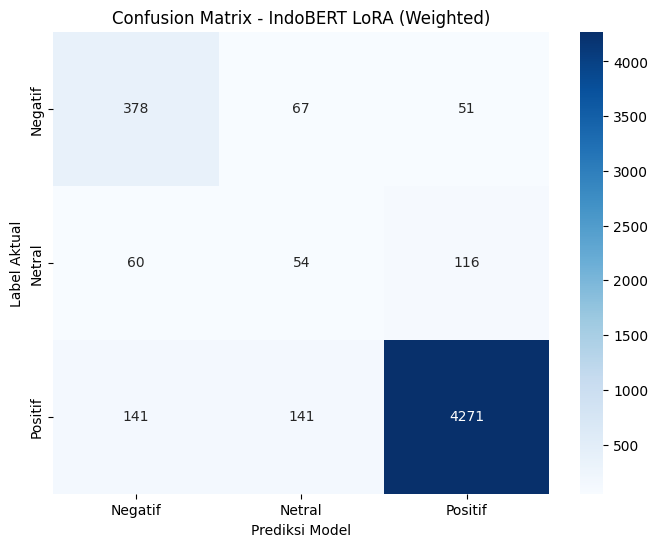

In [38]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# 1. Lakukan Prediksi pada Test Set
print("Melakukan prediksi pada Test Set...")
predictions = trainer.predict(tokenized_datasets["test"])
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids

# 2. Tampilkan Classification Report Detail
target_names = ["Negatif", "Netral", "Positif"]
print("\nLaporan Klasifikasi Detail:")
print(classification_report(labels, preds, target_names=target_names))

# 3. Visualisasi Confusion Matrix
cm = confusion_matrix(labels, preds)

# Hitung persentase untuk analisis yang lebih tajam
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix - IndoBERT LoRA (Weighted)')
plt.ylabel('Label Aktual')
plt.xlabel('Prediksi Model')
plt.show()

In [39]:
# --- SAVE MODEL (LORA ADAPTER) ---
final_model_path = "../models/indobert-lora-finetuned"

print(f"Menyimpan model ke {final_model_path}...")
trainer.save_model(final_model_path)
tokenizer.save_pretrained(final_model_path)

# --- SAVE METRICS TO TEXT ---
with open(os.path.join(final_model_path, "eval_results.txt"), "w") as f:
    f.write(str(trainer.evaluate(tokenized_datasets["test"])))

print("Model berhasil disimpan!")

Menyimpan model ke ../models/indobert-lora-finetuned...


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 53742f38-314f-4767-a23f-92adc25c9df1)')' thrown while requesting HEAD https://huggingface.co/indobenchmark/indobert-base-p1/resolve/main/config.json
Retrying in 1s [Retry 1/5].
/Users/fikrifaizzulfadhli/Python Interpreter/Python 3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Model berhasil disimpan!
